## Contents

1. [What is Covered](#What-is-Covered)
1. [Introduction](#Introduction)
1. [The UCI Credit-card Default Dataset](#The-UCI-Credit-Card-Default-Dataset)
1. [Model training](#Train-the-model)
1. [Credo Binary Classification Fairness Module](#Credo-Fairness-Module)


## What is Covered

* **Domain:**
  * Finance (loan decisions). The data is semisynthetic to create a simple example of disparities in FPR and FNR.

* **ML task:**
  * Binary classification.

## Introduction

In this notebook, we consider a scenario where algorithmic tools are deployed to predict the likelihood that an applicant will default on a credit-card loan. The notebook emulates the problem presented in this [white paper](https://www.microsoft.com/en-us/research/uploads/prod/2020/09/Fairlearn-EY_WhitePaper-2020-09-22.pdf) in collaboration with EY.

Due to data privacy, we do not use the data from the white paper. Instead, we use the [UCI Credit-card default dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients), a toy dataset reflecting credit-card defaults in Taiwan, as a substitute dataset to replicate the desired workflow. To make this dataset applicable to our problem, we introduce a synthethic feature that is highly predictive for applicants defined as "female" in terms of the "sex" feature, but is uninformative for applicants defined as "male".

We train an algorithm on this dataset and show the model has a higher false-positive rate as well as a higher false-negative rate for the "male" group than for the "female" group using the Credo Fairness Module.

In [3]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint
# Data processing
from sklearn.model_selection import train_test_split

# Models
from sklearn.ensemble import GradientBoostingClassifier as gbc

# Credo Fairness Module
from credoai.assessment.model_modules.fairness_base import FairnessModule, list_metrics
# Fairness Reporting
from credoai.reporting.fairness_binaryclassification import FairnessReport
# get aligned metrics from governance platform
from credoai.utils.credo_api_utils import get_aligned_metrics
from credoai.data import fetch_creditdefault

## Prepare Data
### The UCI Credit-Card Default Dataset

The UCI dataset contains data on 30,000 clients and their credit card transactions at a bank in Taiwan. In addition to static client features, the dataset contains the history of credit card bill payments between April and September 2005, as well as the balance limit of the client's credit card. The target is whether the client will default on a card payment in the following month, October 2005. A model trained on this data could be used, in part, to determine whether a client is eligible for another loan or a credit increase.

In [33]:
data = fetch_creditdefault(as_frame=True)
dataset = pd.concat([data['data'], data['target']], axis=1)
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [6]:
dataset.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

Dataset columns:

* `LIMIT_BAL`: credit card limit, will be replaced by a synthetic feature
* `SEX, EDUCATION, MARRIAGE, AGE`: client demographic features
* `BILL_AMT[1-6]`: amount on bill statement for April-September
* `PAY_AMT[1-6]`: payment amount for April-September
* `default payment next month`: target, whether the client defaulted the following month

In [4]:
# Extract the sensitive feature
A = dataset["SEX"]
A_str = A.map({ 2:"female", 1:"male"})
# Extract the target
Y = dataset["default payment next month"].astype(int)

### Introduce a Synthetic Feature

We manipulate the balance-limit feature `LIMIT_BAL` to make it highly predictive for the "female" group but not for the "male" group. Specifically, we set this up, so that a lower credit limit indicates that a female client is less likely to default, but provides no information on a male client's probability of default.

In [5]:
dist_scale = 0.5
np.random.seed(12345)
# Make 'LIMIT_BAL' informative of the target
dataset['LIMIT_BAL'] = Y + np.random.normal(scale=dist_scale, size=dataset.shape[0])
# But then make it uninformative for the male clients
dataset.loc[A==1, 'LIMIT_BAL'] = np.random.normal(scale=dist_scale, size=dataset[A==1].shape[0])

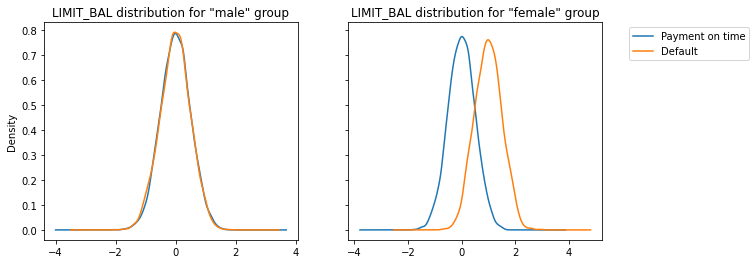

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# Plot distribution of LIMIT_BAL for men
dataset['LIMIT_BAL'][(A==1) & (Y==0)].plot(kind='kde', label="Payment on time", ax=ax1, 
                                           title="LIMIT_BAL distribution for \"male\" group")
dataset['LIMIT_BAL'][(A==1) & (Y==1)].plot(kind='kde', label="Default", ax=ax1)
# Plot distribution of LIMIT_BAL for women
dataset['LIMIT_BAL'][(A==2) & (Y==0)].plot(kind='kde', label="Payment on time", ax=ax2, 
                                           legend=True, title="LIMIT_BAL distribution for \"female\" group")
dataset['LIMIT_BAL'][(A==2) & (Y==1)].plot(kind='kde', label="Default", ax=ax2, 
                                           legend=True).legend(bbox_to_anchor=(1.6, 1))
plt.show()

Note in the above figures that the new `LIMIT_BAL` feature is indeed highly predictive for the "female" group, but not for the "male" group.

In [7]:
# Train-test split
X_train, X_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    dataset.drop(columns=['SEX', 'default payment next month']), 
    Y, 
    A, 
    A_str,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)

## Train the model

This is a "fairness unaware" model. This means it is trained with no consideration to fairness or protected attributes.

We train an out-of-the-box `graident boosted classifier` model on the modified data and assess several fairness metrics. 

In [8]:
model = gbc()
model.fit(X_train, Y_train)

GradientBoostingClassifier()

In [9]:
# Scores on test set
test_scores = model.predict_proba(X_test)[:, 1]

In [10]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

## Credo Fairness Module

The Credo Fairness Module simplifies moving from metric alignment to analysis. The module supports three main functions:

* translates metrics into fairness analysis, including risk assessment based on thresholds
* visualizing fairness metrics
* sending metrics to Credo AI

Many metrics are easily accessible in the module. `credo.fairness_base.list_metrics` gives all of them. You can also extend the functionality with [custom metrics](##Custom-metrics-and-incorporating-confidence-intervals)

In [11]:
aligned_metrics = ['equalized odds difference',
                   'false positive rate',
                   'false negative rate']
fairness_bounds = {'equalized odds difference': (-.1, .1)}
performance_bounds = {'false positive rate': (0, 0.15)}

In [12]:
assessment = FairnessModule(aligned_metrics, 
                A_str_test,
                Y_test,
                test_preds,
                test_scores,
                fairness_bounds,
                performance_bounds
               )

In [13]:
# Get performance metrics disaggregated across senstive features
assessment.get_disaggregated_results(calculate_risk=False)

,false negative rate,false positive rate
SEX,,
female,0.159965,0.140797
male,0.476978,0.160545
overall,0.294827,0.148238


In [14]:
# get fairness metrics which include metrics like "average odds"
# and difference metrics for any performance metric supplied
#
# Note the "method" argument which defines how fairness metrics are calculated
assessment.get_fairness_results(calculate_risk=True, method='between_groups')

,value,risk,acceptable,bound_lower,bound_upper
equalized odds difference,0.317013,0.999951,False,-0.1,0.1
false negative rate,0.317013,NaN,True,-inf,inf
false positive rate,0.019749,NaN,True,-inf,inf


## Reporting

Reports are easily generated. These reports include plots focused on comparing metrics, as well as the creation of disaggregated infographics which summarize performance of the model. 

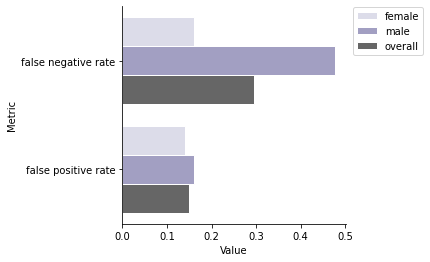

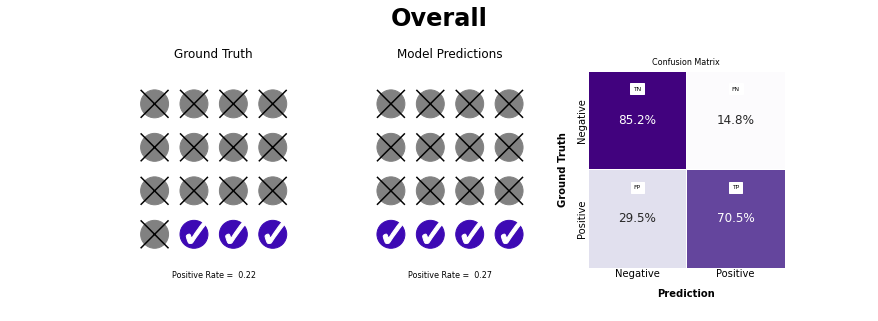

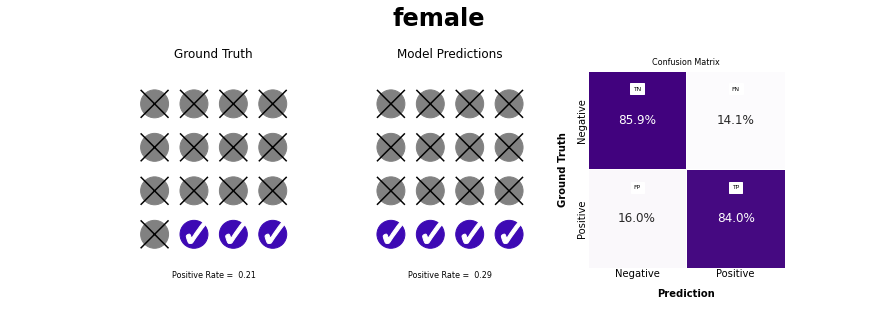

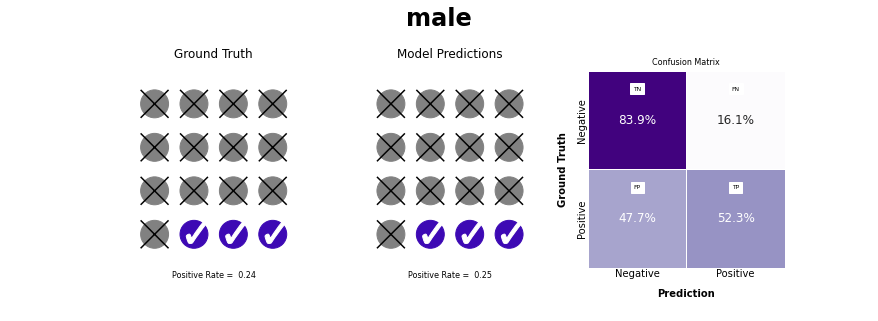

In [16]:
report = FairnessReport(assessment, (4,4), size=4)
report.create_report()

## Custom metrics and incorporating confidence intervals

Custom metrics can be incorporated by creating a `FairnessFunction`. The `FairnessFunction` is a lightweight wrapper class that defines a few characteristics of the custom function needed by the module. 

**Example: Confidence Intervals**

Confidence intervals are not generically supported. However, they can be derived for metrics derived from a confusion matrix using the `wilson confidence interval`. A convenience function called `confusion_wilson` is supplied which returns an array: [lower, upper] bound for the metric. 

However, the module is not designed to accomodate metrics that return arrays. If you wish to incorporate CIs, we'd suggest creating a derived function that returns the lower bound, for example, and then wrapping it in a `FairnessFunction` as we mentioned for custom functions above. We show a case of that below:

In [18]:
from credoai.utils.metrics import confusion_wilson
from credoai.assessment.model_modules.fairness_base import FairnessFunction

# define partial functions for the true positive rate lower bound
def lower_bound_tpr(y_true, y_pred):
    return confusion_wilson(y_true, y_pred, metric='tpr', confidence=0.95)[0]

# and upper bound
def upper_bound_tpr(y_true, y_pred):
    return confusion_wilson(y_true, y_pred, metric='tpr', confidence=0.95)[1]

# wrap the functions in fairness functions
lower_metric = FairnessFunction(name = 'lower_bound_tpr', 
                          func = lower_bound_tpr, 
                          takes_sensitive_features = False, 
                          takes_prob = False)

upper_metric = FairnessFunction(name = 'upper_bound_tpr', 
                          func = upper_bound_tpr, 
                          takes_sensitive_features = False, 
                          takes_prob = False)
           
# then proceed as normally
custom_assessment = FairnessModule([lower_metric, 
                           'true_positive_rate', 
                           upper_metric],
                A_str_test,
                Y_test,
                test_preds,
                test_scores,
                fairness_bounds
               )

custom_assessment.get_disaggregated_results(calculate_risk=False)

,lower_bound_tpr,true_positive_rate,upper_bound_tpr
SEX,,,
female,0.81766,0.840035,0.860134
male,0.489357,0.523022,0.556479
overall,0.684765,0.705173,0.724791
